In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
# import joblib
# import shap

In [126]:
# Load the dataset
df = pd.read_csv('Kag_happiness_indicators.csv')

In [127]:
# Suppression des colonnes inutiles
df_cleaned = df.drop(columns=[ 'Unnamed: 0','widowed',"attend","vhappy","mothfath16","black","gwbush04","female","blackfemale","gwbush00","occattend","regattend","y94","y96","y98","y00","y02","y04","y06","unem10","owngun",'tvhours', 'reg16', 'teens', 'babies', 'preteen', 'divorce'])

# Traitement des valeurs manquantes
# Pour les colonnes numériques, on remplace les NaN par la médiane
numerical_cols = df_cleaned.select_dtypes(include=['float64']).columns
df_cleaned[numerical_cols] = df_cleaned[numerical_cols].apply(lambda x: x.fillna(x.median()))

# Pour les colonnes catégorielles, on remplace les NaN par 'unknown' (ou une catégorie spécifique)
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].apply(lambda x: x.fillna('unknown'))

# Vérification après nettoyage
df_cleaned.info(), df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17137 entries, 0 to 17136
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      17137 non-null  int64  
 1   workstat  17137 non-null  object 
 2   prestige  17137 non-null  float64
 3   educ      17137 non-null  float64
 4   income    17137 non-null  object 
 5   region    17137 non-null  object 
 6   happy     17137 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 937.3+ KB


(None,
    year          workstat  prestige  educ          income           region  \
 0  1994     keeping house      46.0  12.0  $10000 - 14999  middle atlantic   
 1  1994  working fulltime      22.0  12.0         unknown  middle atlantic   
 2  1994  working fulltime      29.0  12.0  $15000 - 19999  middle atlantic   
 3  1994  working fulltime      42.0   8.0  $15000 - 19999  middle atlantic   
 4  1994  working parttime      36.0  13.0  $10000 - 14999  middle atlantic   
 
            happy  
 0   pretty happy  
 1     very happy  
 2   pretty happy  
 3  not too happy  
 4  not too happy  )

In [128]:
import pandas as pd
# 1. Remplacer "unknown" par NaN
df_cleaned.replace("unknown", pd.NA, inplace=True)

# 2. Supprimer les lignes avec NaN dans `divorce` ou `income`
df_clean = df_cleaned.dropna(subset=["income"])

# 3. Réinitialiser l'index
df_clean = df_clean.reset_index(drop=True)

# Affichage des résultats
print("=== RÉSULTATS DU NETTOYAGE ===")
print(f"Nombre de lignes avant suppression : {len(df)}")
print(f"Nombre de lignes après suppression : {len(df_clean)}\n")

print("=== APERÇU DES DONNÉES NETTOYÉES ===")
print(df_clean.head())

print("\n=== STATISTIQUES DESCRIPTIVES ===")
print(df_clean.describe())

print("\n=== VALEURS UNIQUES ===")
print("Income :", df_clean["income"].unique())

=== RÉSULTATS DU NETTOYAGE ===
Nombre de lignes avant suppression : 17137
Nombre de lignes après suppression : 15045

=== APERÇU DES DONNÉES NETTOYÉES ===
   year          workstat  prestige  educ          income           region  \
0  1994     keeping house      46.0  12.0  $10000 - 14999  middle atlantic   
1  1994  working fulltime      29.0  12.0  $15000 - 19999  middle atlantic   
2  1994  working fulltime      42.0   8.0  $15000 - 19999  middle atlantic   
3  1994  working parttime      36.0  13.0  $10000 - 14999  middle atlantic   
4  1994  working parttime      43.0  15.0  $25000 or more  middle atlantic   

           happy  
0   pretty happy  
1   pretty happy  
2  not too happy  
3  not too happy  
4   pretty happy  

=== STATISTIQUES DESCRIPTIVES ===
               year      prestige          educ
count  15045.000000  15045.000000  15045.000000
mean    1999.447923     43.948887     13.400266
std        4.133270     13.559072      2.959866
min     1994.000000     17.000000  

In [129]:
# Check for missing values
print("Missing values:\n", df_clean.isnull().sum())

# Check data types
print("\nData types:\n", df_clean.dtypes)

# Check class balance
print("\nClass distribution:\n", df_clean['happy'].value_counts(normalize=True))

Missing values:
 year        0
workstat    0
prestige    0
educ        0
income      0
region      0
happy       0
dtype: int64

Data types:
 year          int64
workstat     object
prestige    float64
educ        float64
income       object
region       object
happy        object
dtype: object

Class distribution:
 happy
pretty happy     0.576537
very happy       0.303290
not too happy    0.120173
Name: proportion, dtype: float64


In [130]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Separate features and target
X = df_cleaned.drop(columns=['happy'])  # Use raw cleaned DataFrame
y = df_cleaned['happy'].apply(lambda x: 1 if x in ['very happy', 'pretty happy'] else 0)

# Identify column types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine into preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Ensure missing values are filled with strings
for col in categorical_cols:
    X[col] = X[col].astype(str).fillna('unknown').replace('nan', 'unknown')

# Fit and save the preprocessor
preprocessor.fit(X)


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['year', 'prestige', 'educ']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['workstat', 'income', 'region'])])

In [131]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import joblib

# Ensure that X and y are your feature matrix and target vector
# X = your_feature_data
# y = your_target_data

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns  # Adjust for both int and float types

# Categorical pipeline (handle missing values + encode categories)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  # Handle missing categorical data
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # OneHotEncode, sparse=False for a dense output
])

# Numerical pipeline (handle missing values)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))  # Handle missing numerical data
])

# Apply preprocessor to both numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the full pipeline (preprocessing + model)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression Model
])

# Split your data into training and testing sets if not done already
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test set using the pipeline
y_pred = pipeline.predict(X_test)



In [132]:
# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred))

# Perform 5-fold cross-validation and evaluate performance
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation of cross-validation accuracy: {np.std(cv_scores):.4f}")

Accuracy on test set: 0.8760210035005834


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Cross-validation accuracy scores: [0.87660443 0.87835473 0.87831923 0.87423402 0.87744383]
Mean cross-validation accuracy: 0.8770
Standard deviation of cross-validation accuracy: 0.0015


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


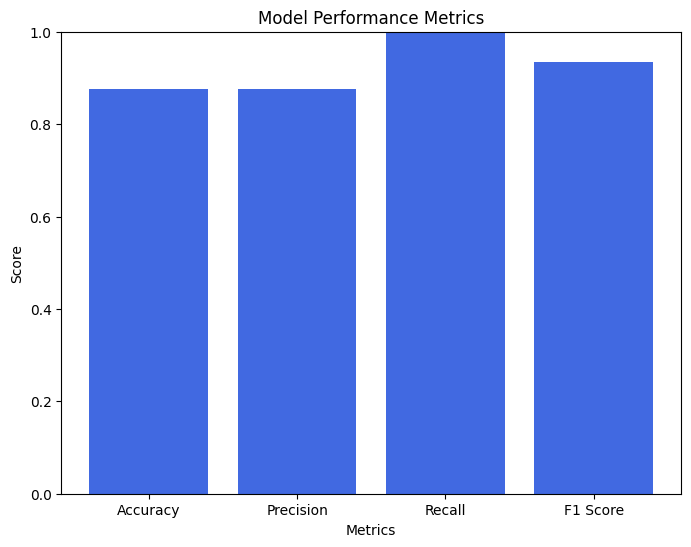

In [133]:
import matplotlib.pyplot as plt

# Performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    f1_score(y_test, y_pred)
]

# Plotting the metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color='royalblue')
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

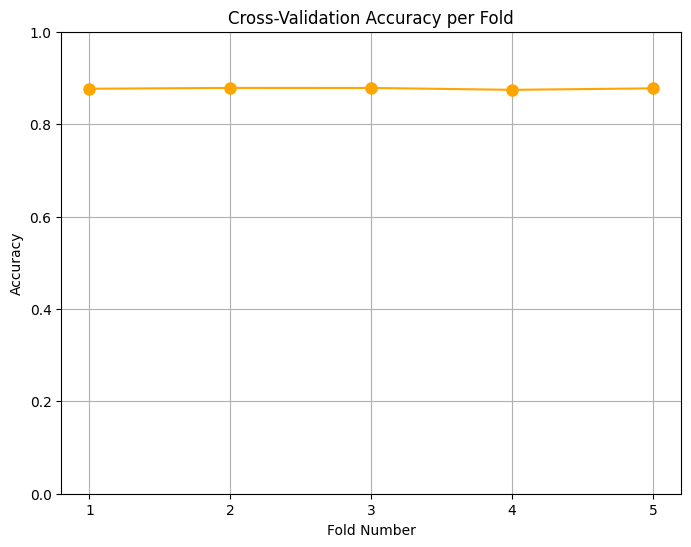

In [134]:
# Perform cross-validation (5-fold in this case)
cvScores = cross_val_score(pipeline, X, y, cv=5)

# Plotting the cross-validation results (accuracy per fold)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cvScores) + 1), cvScores, marker='o', color='orange', linestyle='-', markersize=8)
plt.title('Cross-Validation Accuracy per Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(range(1, len(cvScores) + 1))
plt.grid(True)
plt.show()

In [135]:
import joblib

# Save the best model
joblib.dump(model, 'happiness_predictor.pkl')

# Save the preprocessor and the model
joblib.dump(preprocessor, 'preprocessor.pkl')
# Save the entire pipeline (including the preprocessor and model)
joblib.dump(pipeline, 'logistic_regression_pipeline.pkl')

['logistic_regression_pipeline.pkl']